In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/advanced-dls-spring-2021/submission.csv
/kaggle/input/advanced-dls-spring-2021/train.csv
/kaggle/input/advanced-dls-spring-2021/test.csv


In [3]:
import seaborn as sns

from catboost import CatBoostClassifier
from matplotlib import pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from pprint import pprint
from warnings import filterwarnings

filterwarnings("ignore", category=FutureWarning)

In [4]:
INPUT_DIR = "../input/advanced-dls-spring-2021/"
OUTPUT_DIR = "./"
data = pd.read_csv(INPUT_DIR + "train.csv")
X_test = pd.read_csv(INPUT_DIR + "test.csv")

In [5]:
data.shape

(5282, 20)

In [6]:
data.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [7]:
data.sample(5, random_state=0)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
4650,66,20.35,1359.5,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Electronic check,0
29,25,89.70,2187.55,Female,1,No,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,1
1688,36,76.35,2606.35,Female,0,No,No,Yes,No,DSL,Yes,Yes,Yes,Yes,Yes,No,One year,Yes,Mailed check,0
2946,20,19.60,356.15,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Credit card (automatic),0
4865,13,98.00,1237.85,Male,1,Yes,No,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,1


In [8]:
num_cols = [
    "ClientPeriod",
    "MonthlySpending",
    "TotalSpent",
]

cat_cols = [
    "Sex",
    "IsSeniorCitizen",
    "HasPartner",
    "HasChild",
    "HasPhoneService",
    "HasMultiplePhoneNumbers",
    "HasInternetService",
    "HasOnlineSecurityService",
    "HasOnlineBackup",
    "HasDeviceProtection",
    "HasTechSupportAccess",
    "HasOnlineTV",
    "HasMovieSubscription",
    "HasContractPhone",
    "IsBillingPaperless",
    "PaymentMethod",
]

target = 'Churn'

In [9]:
print(f"Duplicated rows: {data.duplicated(keep=False).sum()}")
print(f"Duplicated rows without target: {data.drop(target, axis=1).duplicated(keep=False).sum()}")

Duplicated rows: 28
Duplicated rows without target: 41


In [10]:
data[data.drop(target, axis=1).duplicated(keep=False)].sort_values(by=[*data.columns])

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
838,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1636,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4811,1,19.65,19.65,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3463,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
4294,1,19.75,19.75,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
3831,1,20.00,20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1647,1,20.00,20,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,1
594,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
1474,1,20.05,20.05,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0
3735,1,20.20,20.2,Male,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,0


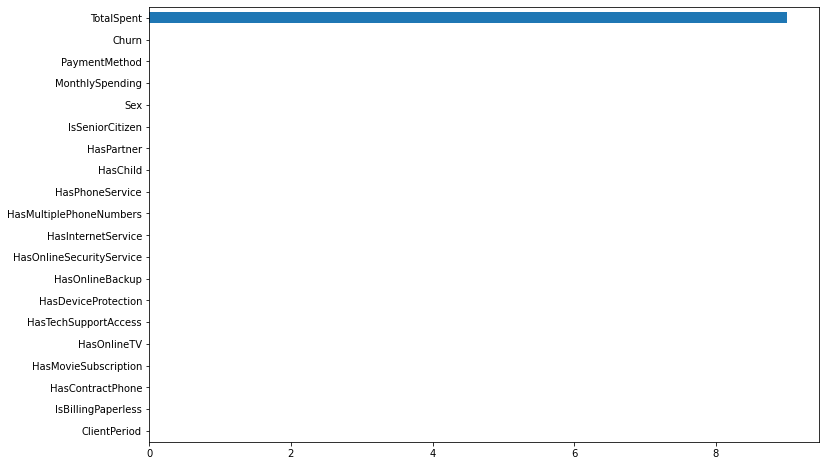

In [11]:
data.replace(" ", np.nan, inplace=True)
X_test.replace(" ", np.nan, inplace=True)
pd.DataFrame(data.isna().sum(), columns=["NaN Count"]) \
    .sort_values("NaN Count") \
    .plot(kind="barh", legend=False, figsize=(12, 8));

In [12]:
data.sort_values("TotalSpent").tail(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1157,11,94.20,999.9,Female,0,No,No,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,Month-to-month,Yes,Electronic check,0
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [14]:
data["TotalSpent"] = data.TotalSpent.fillna(0).astype(float)
X_test["TotalSpent"] = X_test.TotalSpent.fillna(0).astype(float)

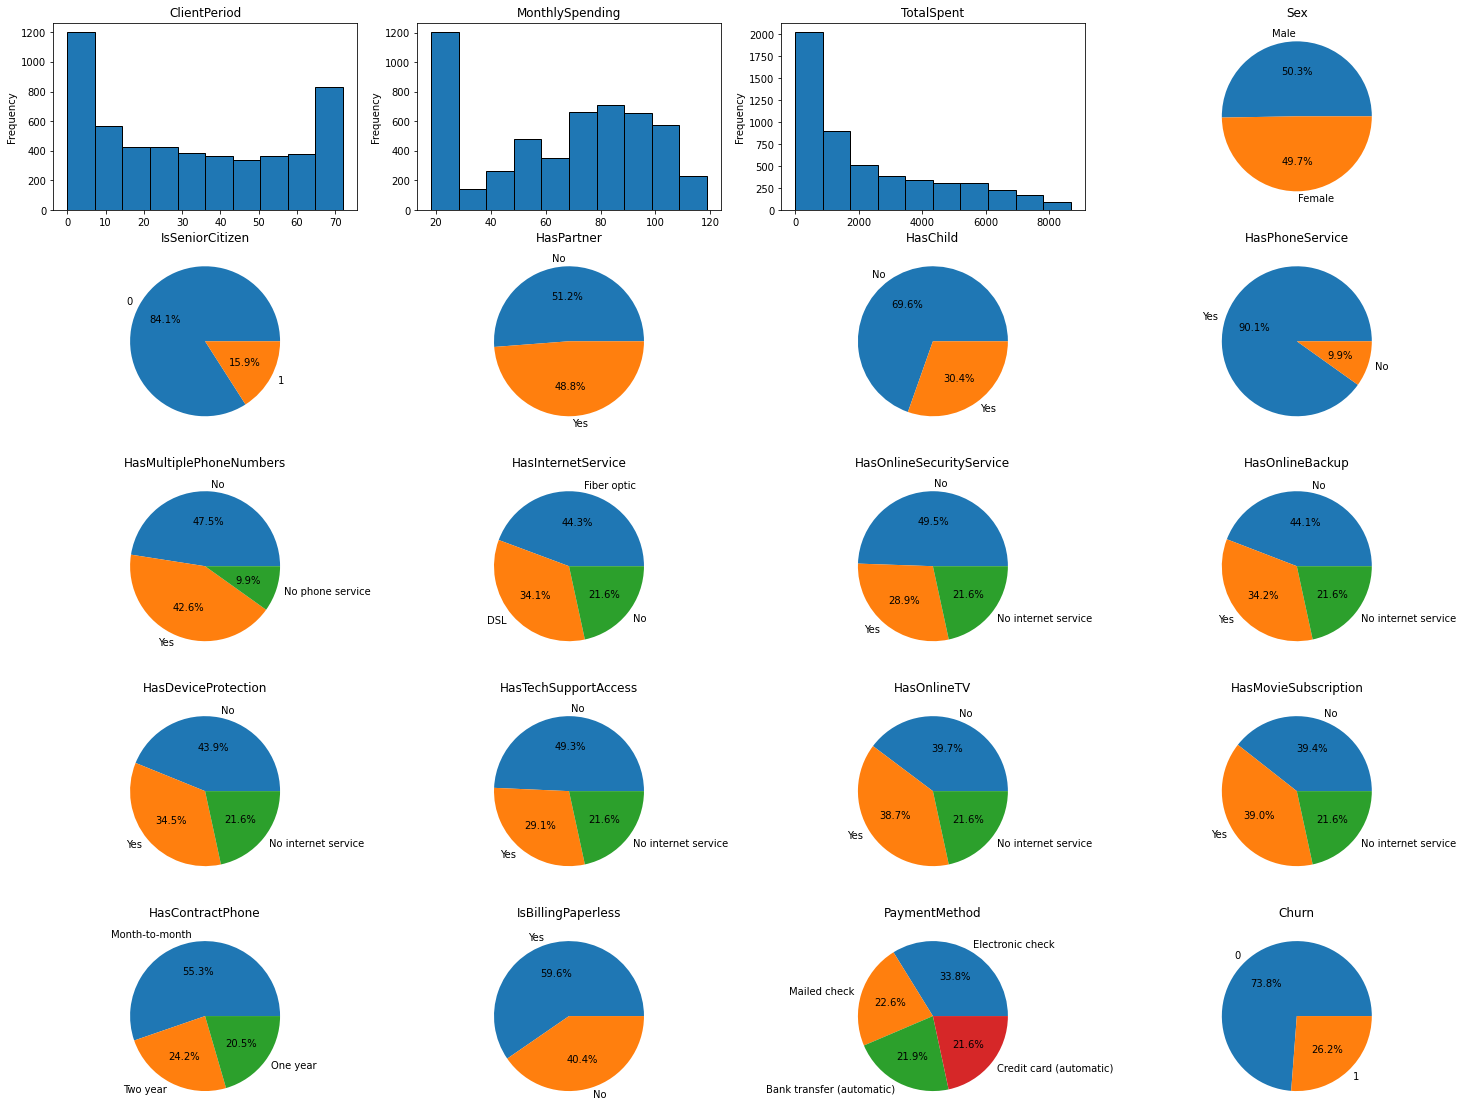

In [15]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
for ax, col in zip(axes.flatten(), data.columns):
    ax.set_title(col)
    if col in cat_cols or col == target:
        ax.pie(data[col].value_counts(), autopct="%1.1f%%", labels=data[col].value_counts().index)
    else:
        data[col].plot(kind="hist", ec="black", ax=ax)

In [16]:
tmp = data.groupby("PaymentMethod", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

PaymentMethod Churn        Churn (%)
                               sum count           
0    Credit card (automatic)   165  1143  14.435696
1  Bank transfer (automatic)   195  1159  16.824849
2               Mailed check   230  1194  19.262982
3           Electronic check   794  1786  44.456887

In [17]:
tmp = data.groupby("HasContractPhone", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

HasContractPhone Churn        Churn (%)
                     sum count           
0         Two year    33  1280   2.578125
1         One year   120  1082  11.090573
2   Month-to-month  1231  2920  42.157534

In [18]:
tmp = data.groupby("HasInternetService", as_index=False).agg({"Churn": ["sum", "count"]})
tmp["Churn (%)"] = 100 * tmp["Churn", "sum"] / tmp["Churn", "count"]
tmp.sort_values("Churn (%)").reset_index(drop=True)

HasInternetService Churn        Churn (%)
                       sum count           
0                 No    82  1141   7.186678
1                DSL   342  1800  19.000000
2        Fiber optic   960  2341  41.008116

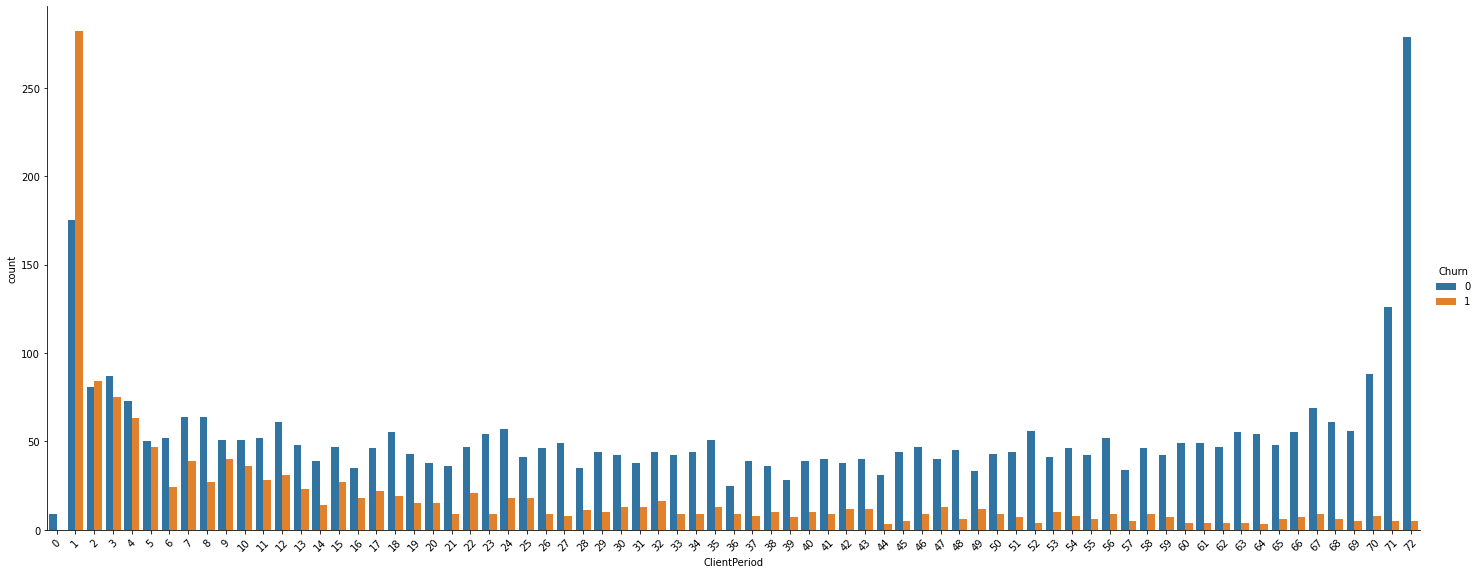

In [19]:
sns.catplot(data=data, x="ClientPeriod", hue="Churn", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45);

In [20]:
patterns = {
    "No": 0,
    "No internet service": 0,
    "No phone service": 0,
    "Yes": 1,
    "Male": 0,
    "Female": 1,
    "DSL": 1,
    "Fiber optic": 2,
    "Month-to-month": 0,
    "One year": 1,
    "Two year": 2,
    "Credit card (automatic)": 0,
    "Bank transfer (automatic)": 1,
    "Mailed check": 2,
    "Electronic check": 3,
}
X_train = data.replace(patterns).drop(target, axis=1)
y_train = data[target]
X_test = X_test.replace(patterns)

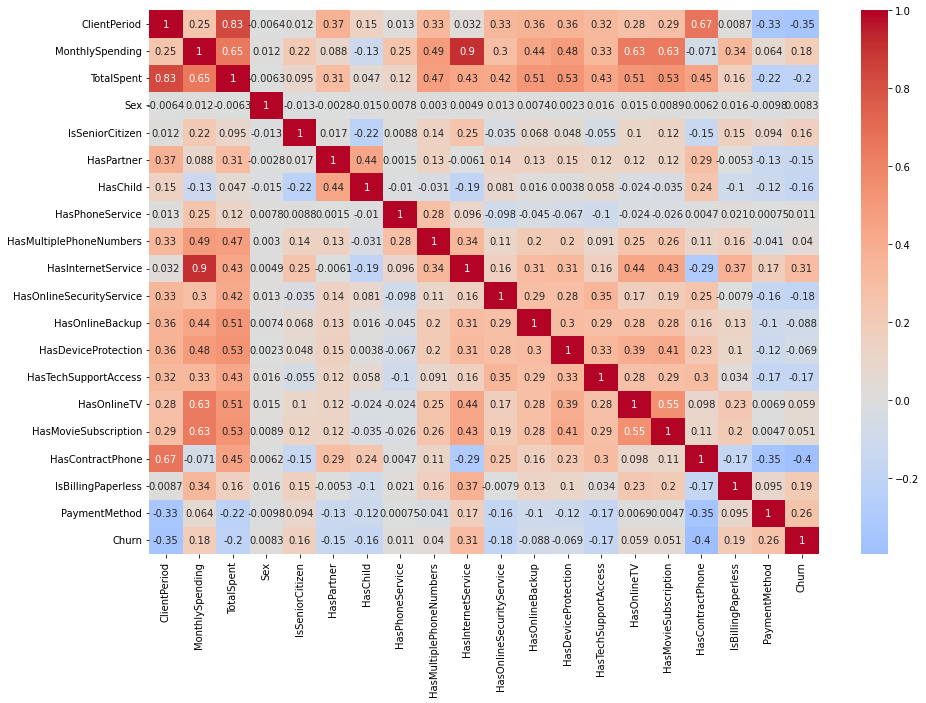

In [21]:
sns.heatmap(data=pd.concat([X_train, y_train], axis=1).corr(),
            annot=True,
            cmap="coolwarm",
            center=0,
            ax=plt.subplots(figsize=(15,10))[1]);

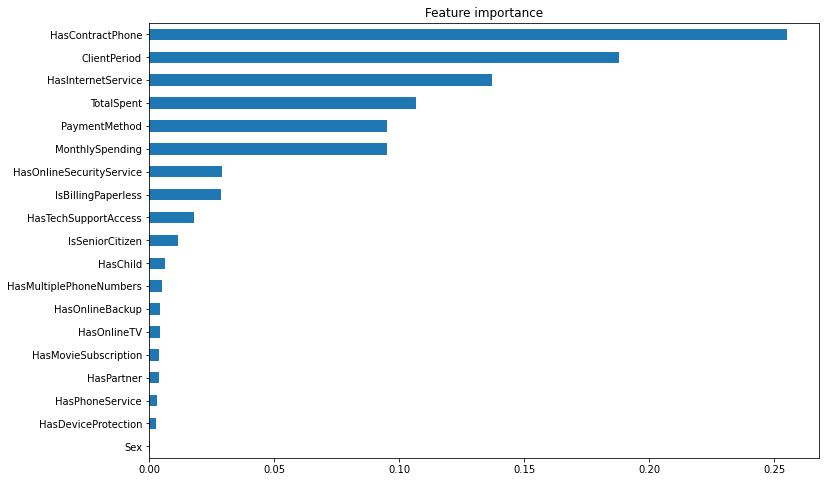

In [22]:
clf = RandomForestClassifier(n_estimators=1000, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

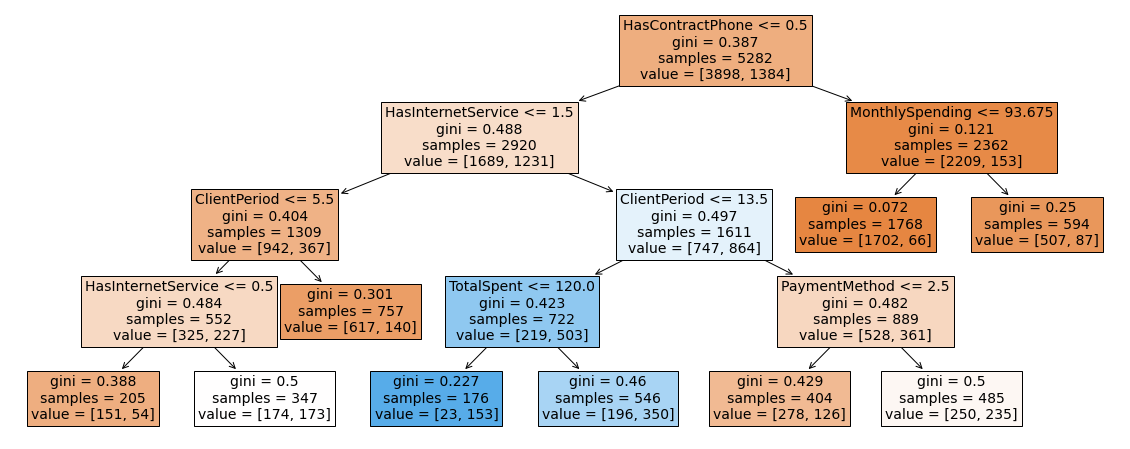

In [23]:
clf = DecisionTreeClassifier(min_impurity_decrease=0.002)
clf.fit(X_train, y_train)
plt.figure(figsize=(20, 8))
plot_tree(clf, fontsize=14, feature_names=X_train.columns, filled=True)
plt.show()

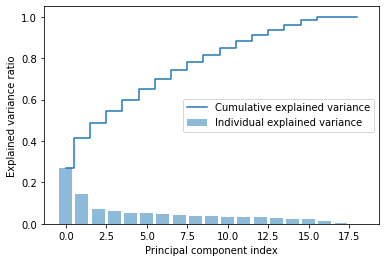

In [24]:
X_train_std = StandardScaler().fit_transform(X_train)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

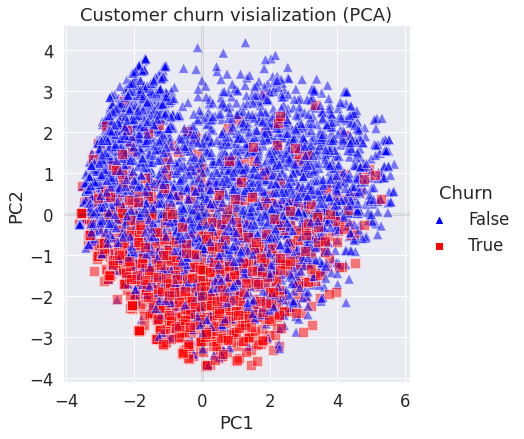

In [25]:
pca = PCA(n_components=2)
pca.fit(X_train_std)
x0, x1 = pca.components_
sns.set(font_scale=1.5)
y = data["Churn"].map({0: False, 1: True})
fig = sns.pairplot(data=pd.concat([pd.DataFrame(data=X_train_std @ np.stack([x0, x1]).T, columns=["PC1", "PC2"]), y], axis=1),
                   x_vars="PC1",
                   y_vars="PC2",
                   hue="Churn",
                   markers=('^', 's'),
                   palette=["blue", "red"],
                   plot_kws={'s': 100, 'alpha': 0.5},
                   height=6)
fig.set(title="Customer churn visialization (PCA)")
fig.axes[0][0].axhline(y=0, color='black', lw=3, alpha=0.1)
fig.axes[0][0].axvline(x=0, color='black', lw=3, alpha=0.1);


In [26]:
%%time
PARAMS = {
    "model__C": [1.734],  # np.arange(0.001, 100, 0.001)
}
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42)),
])
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
logreg = grid_search.fit(X_train, y_train)

CPU times: user 437 ms, sys: 36 ms, total: 473 ms
Wall time: 4.12 s


In [27]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

best score: 0.8451031617037706
best params: {'model__C': 1.734}


In [28]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = logreg.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "logreg.csv", index=False)

In [29]:
catboost = CatBoostClassifier(
    cat_features=cat_cols,
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=0,
)

PARAMS = {
    "n_estimators": [250],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],  # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],  # [3, 5, 7, 10],
    "random_strength": [5],  # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],  # np.arange(10, 1001, 10),
}
catboost.grid_search(PARAMS, X_train, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8681264	best: 0.8681264 (0)	total: 1.74s	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 100,
  'random_strength': 5,
  'depth': 4,
  'l2_leaf_reg': 10,
  'iterations': 250,
  'subsample': 0.6,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 249],
              'test-AUC-mean': [0.6738448428910353, 0.848150440977052],
              'test-AUC-std': [0.03568219871124697, 0.01491232030260835],
              'train-AUC-mean': [0.674286151981913, 0.8662277514836992],
              'train-AUC-std': [0.045687735616764, 0.0030760473170784734],
              'test-Logloss-mean': [0.6746293084649804, 0.41027763916805615],
              'test-Logloss-std': [0.0012264681423689151, 0.01760761641175248],
              'train-Logloss-mean': [0.6745106344821561, 0.38913850934181715],
              'train-Logloss-std': [0.0015597023202042711,
               0.0041976582161760475]})}

In [30]:
print("Best score:", end=' ')
pprint(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
pprint(best_params)

Best score: {'learn': {'AUC': 0.8642032782485164, 'Logloss': 0.39144271235447}}
Best params: {'depth': 4,
 'grow_policy': 'Lossguide',
 'iterations': 250,
 'l2_leaf_reg': 10,
 'learning_rate': 0.05,
 'metric_period': 1000,
 'min_data_in_leaf': 100,
 'random_seed': 0,
 'random_strength': 5,
 'subsample': 0.6}


In [31]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = catboost.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "catboost.csv", index=False)

In [33]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)
PARAMS = {
    "model__n_neighbors": [44],  # range(1, 100),
    "model__metric": ["manhattan"],  # ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "nan_euclidean"],
}

clf = Pipeline(steps=[
    ("preproc", preprocessor),
    ("model", KNeighborsClassifier()),
])
    
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="roc_auc",
    n_jobs=-1,
    cv=10,
    refit=True,
)
knn = grid_search.fit(X_train, y_train)

In [34]:
print(f"best score: {knn.best_score_}")
print(f"best params: {knn.best_params_}")

best score: 0.8347721646087625
best params: {'model__metric': 'manhattan', 'model__n_neighbors': 44}


In [35]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = knn.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "knn.csv", index=False)

In [36]:
PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [18],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X_train, y_train);

In [37]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.8433171488881694
Best params: {'min_samples_leaf': 18, 'min_samples_split': 9}


In [38]:
submission = pd.read_csv(INPUT_DIR + "submission.csv")
submission["Churn"] = rf.predict_proba(X_test)[:, 1]
submission.to_csv(OUTPUT_DIR + "rf.csv", index=False)

In [39]:
meta = CatBoostClassifier(
    logging_level='Silent',
    eval_metric="AUC:hints=skip_train~false",
    metric_period=1000,
    random_seed=0,
    grow_policy="Depthwise",
    l2_leaf_reg=1,
    learning_rate=0.08,
    max_depth=10,
    min_data_in_leaf=10,
    n_estimators=10,
    random_strength=11,
    subsample=0.1,
)
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("knn", knn),
        ("rf", rf),
        ("catboost", catboost),
    ],
    final_estimator=meta,
    n_jobs=-1,
)

stacking.fit(X_train, y_train)

StackingClassifier(estimators=[('logreg',
                                GridSearchCV(cv=10,
                                             estimator=Pipeline(steps=[('scaler',
                                                                        StandardScaler()),
                                                                       ('model',
                                                                        LogisticRegression(max_iter=1000,
                                                                                           penalty='l1',
                                                                                           random_state=42,
                                                                                           solver='saga'))]),
                                             n_jobs=-1,
                                             param_grid={'model__C': [1.734]},
                                             scoring='roc_auc')),
                      

In [41]:
best_model = stacking

In [43]:
y_pred = best_model.predict_proba(X_test)[:, 1]
submission = pd.read_csv(INPUT_DIR + "./submission.csv")
submission['Churn'] = y_pred
submission.to_csv(OUTPUT_DIR + "./my_submission.csv", index=False)

In [44]:
submission.to_csv(OUTPUT_DIR + "./submission.csv", index=False)